## Grafo non connesso

Cluster assignments:
{0: {0, 1, 2, 3, 4, 5, 6, 8}, 1: {9, 7}}
Dimensione del multi-cut minimo: 2
Tempo di esecuzione: 0.0013155937194824219 secondi


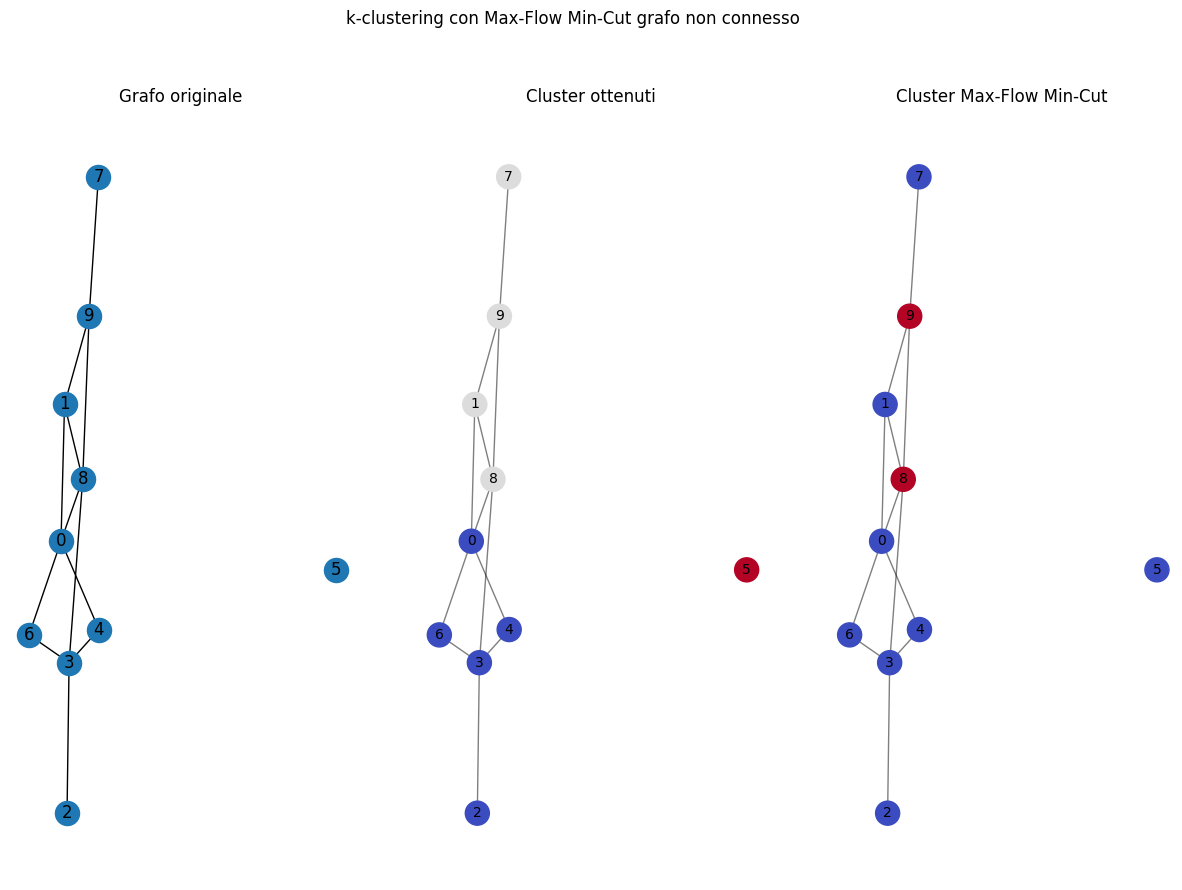

In [31]:
import networkx as nx
import matplotlib.pyplot as plt
import community
import time

# Registra l'istante di inizio dell'esecuzione
start_time = time.time()

# Creazione di un grafo casuale con 10 nodi e 15 archi
G = nx.gnm_random_graph(n=10, m=12, seed=42)  # Aggiungi 'seed' per riproducibilità

# Assegna pesi finiti agli archi del grafo casuale
for u, v in G.edges():
    G.edges[u, v]['capacity'] = 1  # Imposta la capacità a 1 (puoi modificare questo valore a tuo piacimento)

# Estraiamo le feature dei nodi (esempio: gradi dei nodi)
node_degrees = dict(G.degree())

# Convertiamo i gradi dei nodi in una lista di feature
node_features = [degree for node, degree in node_degrees.items()]

# Calcoliamo la partizione ottimale basata sulla modolarità utilizzando Louvain
partition = community.best_partition(G)

# Aggiungi l'etichetta del cluster come attributo per ogni nodo del grafo
nx.set_node_attributes(G, partition, 'cluster_label')

# Scegli i nodi sorgente e destinazione per l'algoritmo Max-Flow Min-Cut
source_node = 0
target_node = 9

# Troviamo il taglio minimo utilizzando l'algoritmo Max-Flow Min-Cut
cut_value, (set_source, set_target) = nx.minimum_cut(G, source_node, target_node)

# Creiamo un dizionario per rappresentare la partizione ottenuta dal taglio minimo
partition_dict = {0: set_source, 1: set_target}

# Creiamo un dizionario di colori personalizzato per mappare ciascun cluster a un valore numerico
color_map = {node: idx for idx, nodes in partition_dict.items() for node in nodes}

# Stampa dell'output: dizionario dei cluster e dimensione del multi-cut minimo
print("Cluster assignments:")
print(partition_dict)
print("Dimensione del multi-cut minimo:", cut_value)

# Registra l'istante di fine dell'esecuzione
end_time = time.time()

# Calcola il tempo di esecuzione in secondi
execution_time = end_time - start_time

# Stampa il tempo di esecuzione
print("Tempo di esecuzione:", execution_time, "secondi")

# Per visualizzare i cluster
pos = nx.spring_layout(G)  # Layout per posizionare i nodi
plt.figure(figsize=(15, 10))  # Dimensione della figura
plt.suptitle("k-clustering con Max-Flow Min-Cut grafo non connesso")

# Prima visualizzazione: Grafo originale con etichette dei nodi
plt.subplot(1, 3, 1)
plt.axis("off")
nx.draw_networkx(G, pos, with_labels=True)
plt.title("Grafo originale")

# Seconda visualizzazione: Cluster ottenuti da Louvain
plt.subplot(1, 3, 2)
plt.axis("off")
# Coloriamo i nodi in base all'etichetta del cluster
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')
plt.title("Cluster ottenuti")

# Terza visualizzazione: Cluster ottenuti da Max-Flow Min-Cut
plt.subplot(1, 3, 3)
plt.axis("off")
# Coloriamo i nodi in base alla partizione ottenuta
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(color_map.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')
plt.title("Cluster Max-Flow Min-Cut")


plt.show()


## Grafo connesso


Cluster assignments:
{0: {0, 1, 2, 3, 4, 5, 6, 8}, 1: {9, 7}}
Dimensione del multi-cut minimo: 2
Tempo di esecuzione: 0.24171090126037598 secondi


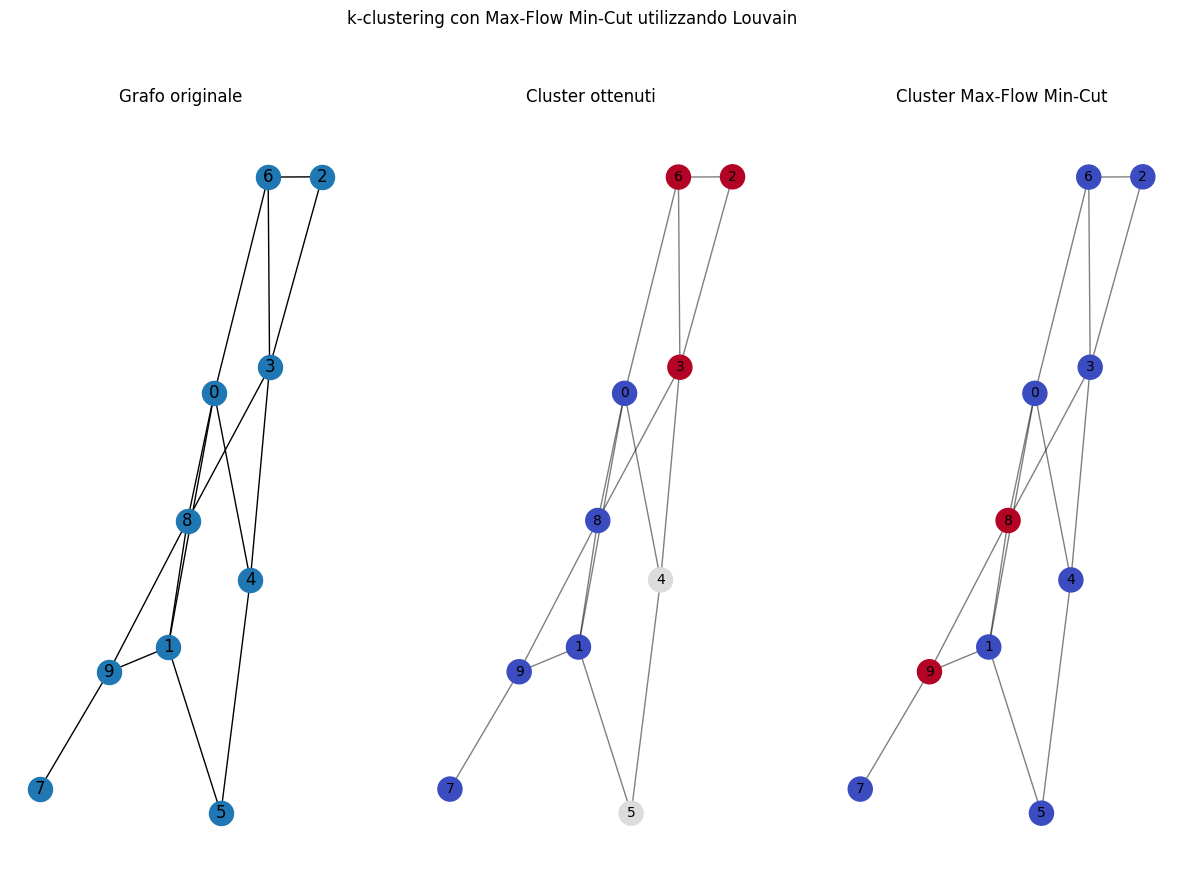

In [32]:
import networkx as nx
import matplotlib.pyplot as plt
import random

# Creazione di un grafo casuale con 10 nodi e 15 archi
G = nx.gnm_random_graph(n=10, m=15, seed=42)

# Verifica se il grafo è connesso
if not nx.is_connected(G):
    # Aggiungi archi casuali fino a quando il grafo diventa connesso
    while not nx.is_connected(G):
        u = random.choice(list(G.nodes()))
        v = random.choice(list(G.nodes()))
        if u != v and not G.has_edge(u, v):
            G.add_edge(u, v)


# Assegna pesi finiti agli archi del grafo casuale
for u, v in G.edges():
    G.edges[u, v]['capacity'] = 1  # Imposta la capacità a 1 (puoi modificare questo valore a tuo piacimento)

# Estraiamo le feature dei nodi (esempio: gradi dei nodi)
node_degrees = dict(G.degree())

# Convertiamo i gradi dei nodi in una lista di feature
node_features = [degree for node, degree in node_degrees.items()]

# Calcoliamo la partizione ottimale basata sulla modolarità utilizzando Louvain
partition = community.best_partition(G)

# Aggiungi l'etichetta del cluster come attributo per ogni nodo del grafo
nx.set_node_attributes(G, partition, 'cluster_label')

# Scegli i nodi sorgente e destinazione per l'algoritmo Max-Flow Min-Cut
source_node = 0
target_node = 9

# Troviamo il taglio minimo utilizzando l'algoritmo Max-Flow Min-Cut
cut_value, (set_source, set_target) = nx.minimum_cut(G, source_node, target_node)

# Creiamo un dizionario per rappresentare la partizione ottenuta dal taglio minimo
partition_dict = {0: set_source, 1: set_target}

# Creiamo un dizionario di colori personalizzato per mappare ciascun cluster a un valore numerico
color_map = {node: idx for idx, nodes in partition_dict.items() for node in nodes}

# Stampa dell'output: dizionario dei cluster e dimensione del multi-cut minimo
print("Cluster assignments:")
print(partition_dict)
print("Dimensione del multi-cut minimo:", cut_value)

# Registra l'istante di fine dell'esecuzione
end_time = time.time()

# Calcola il tempo di esecuzione in secondi
execution_time = end_time - start_time

# Stampa il tempo di esecuzione
print("Tempo di esecuzione:", execution_time, "secondi")

# Per visualizzare i cluster
pos = nx.spring_layout(G)  # Layout per posizionare i nodi
plt.figure(figsize=(15, 10))  # Dimensione della figura
plt.suptitle("k-clustering con Max-Flow Min-Cut utilizzando Louvain")

# Prima visualizzazione: Grafo originale con etichette dei nodi
plt.subplot(1, 3, 1)
plt.axis("off")
nx.draw_networkx(G, pos, with_labels=True)
plt.title("Grafo originale")

# Seconda visualizzazione: Cluster ottenuti da Louvain
plt.subplot(1, 3, 2)
plt.axis("off")
# Coloriamo i nodi in base all'etichetta del cluster
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')
plt.title("Cluster ottenuti")

# Terza visualizzazione: Cluster ottenuti da Max-Flow Min-Cut
plt.subplot(1, 3, 3)
plt.axis("off")
# Coloriamo i nodi in base alla partizione ottenuta
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(color_map.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')
plt.title("Cluster Max-Flow Min-Cut")

plt.show()

            

### Problema di ottimizzazione 
#### PLI

Per formulare il problema del multi-cut minimo come un problema di Programmazione Lineare (LP) o Programmazione Intera (IP), dovremo definire le variabili, la funzione obiettivo e i vincoli del problema in modo appropriato.

Supponiamo di avere un grafo G=(V, E), dove V è l'insieme dei nodi e E è l'insieme degli archi. Definiamo le seguenti variabili decisionali:

1. Variabili binarie:
   - x_ij: variabile binaria che assume valore 1 se l'arco (i, j) è presente nel taglio (cioè i e j appartengono a sottografi diversi), altrimenti assume valore 0.

2. Variabili continue (opzionali):
   - y_i: variabile continua che rappresenta una misura di quanto il nodo i è associato al cluster 1 (o al cluster principale).

La *funzione obiettivo* sarà minimizzare la somma dei valori delle variabili x_ij per tutti gli archi (i, j):

#### Minimizza: Σ x_ij

#### Soggetto ai seguenti vincoli:

1. Vincolo di connettività:
   Per ogni nodo i, la somma delle variabili x_ij per tutti gli archi (i, j) incidenti al nodo i deve essere uguale a 1. Questo vincolo garantisce che ogni nodo sia assegnato a un solo sottografo.

   Σ x_ij = 1, per ogni nodo i ∈ V

2. Vincolo sulle variabili binarie:
   Le variabili binarie x_ij devono essere comprese tra 0 e 1.

   0 ≤ x_ij ≤ 1, per ogni arco (i, j) ∈ E

3. Vincoli di bilanciamento (opzionali):
   Se si utilizzano le variabili continue y_i per misurare l'associazione del nodo i al cluster principale, dovremmo aggiungere vincoli di bilanciamento per controllare l'assegnazione dei nodi ai sottografi.

   - Se il nodo i appartiene al cluster principale, allora y_i = 1.
   - Se il nodo i appartiene al cluster secondario, allora y_i = 0.

Con queste variabili e vincoli, il problema diventa un problema di ottimizzazione lineare o intera. Se tutte le variabili sono continue, otteniamo un problema di Programmazione Lineare (LP). Se almeno una variabile è discreta (binaria), otteniamo un problema di Programmazione Intera (IP).


Status: Optimal
Archi del multi-cut:
(0, 8)
(1, 5)
(2, 6)
(3, 4)
(7, 9)
Tempo di esecuzione: 0.5165832042694092 secondi


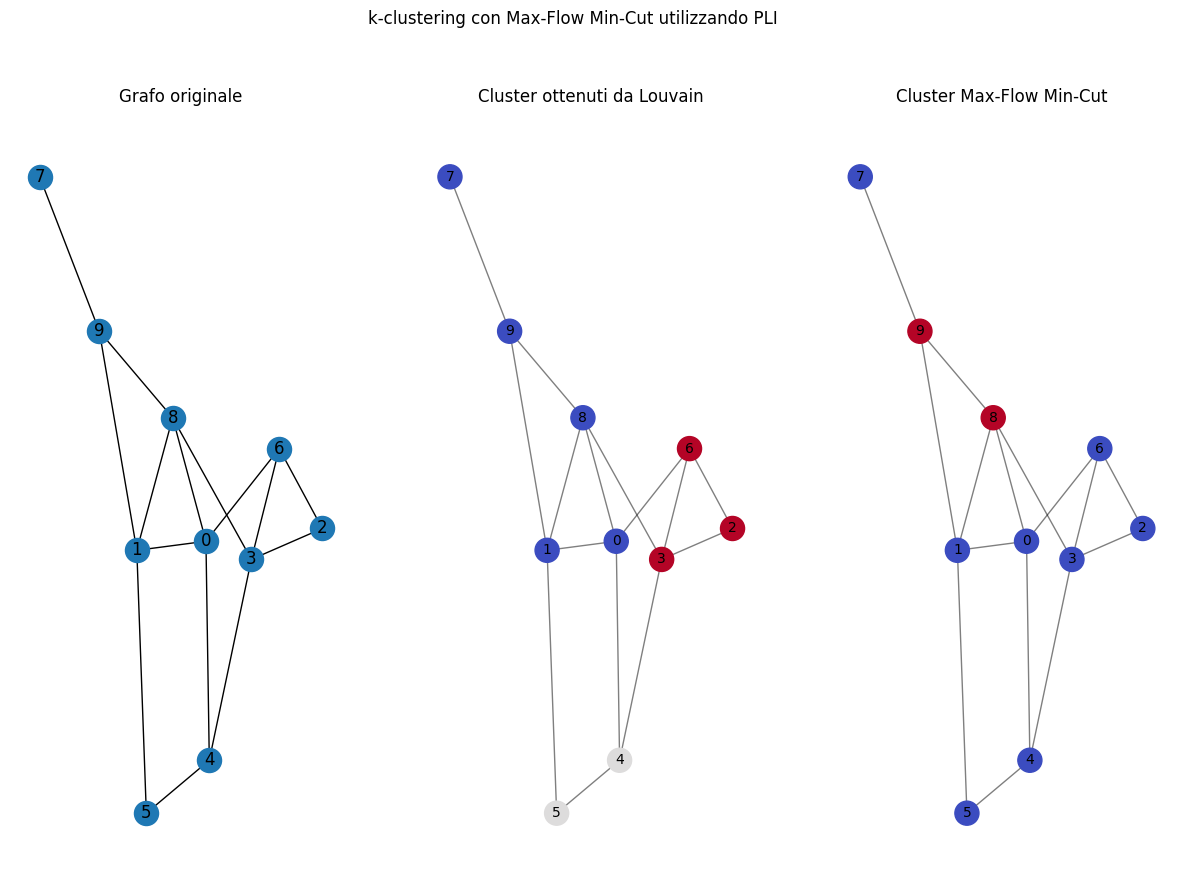

In [33]:
import networkx as nx
import matplotlib.pyplot as plt
import pulp
import time

time_start = time.time()

# Creazione del grafo casuale
G = nx.gnm_random_graph(n=10, m=15, seed=42)


# Definizione del problema di ottimizzazione
prob = pulp.LpProblem("Minimum_MultiCut", pulp.LpMinimize)

# Variabili binarie x_ij
x = pulp.LpVariable.dicts("x", G.edges(), lowBound=0, upBound=1, cat=pulp.LpBinary)

# Funzione obiettivo: minimizzare la somma dei valori delle variabili x_ij
prob += pulp.lpSum(x[edge] for edge in G.edges())

# Vincolo di connettività: ogni nodo i deve essere assegnato a un solo sottografo
for node in G.nodes():
    prob += pulp.lpSum(x[(i, j)] for i, j in G.edges() if i == node or j == node) == 1

# Se si utilizzano le variabili continue y_i per misurare l'associazione del nodo i al cluster principale,
# dovremmo aggiungere i vincoli di bilanciamento:
# y_i = 1 se il nodo i appartiene al cluster principale, y_i = 0 altrimenti

# Risoluzione del problema
#prob.solve()
prob.solve(pulp.PULP_CBC_CMD(msg=0))

# Stampa del risultato
print("Status:", pulp.LpStatus[prob.status])

# Stampa delle variabili binarie con valore 1 (i.e., archi del multi-cut)
print("=====================================================")
print("Archi del multi-cut:")
print("=====================================================")
for edge in G.edges():
    if pulp.value(x[edge]) == 1:
        print(edge)

# Registra l'istante di fine dell'esecuzione
end_time = time.time()

# Calcola il tempo di esecuzione in secondi
execution_time = end_time - start_time

print("=====================================================")
print("Tempo di esecuzione:", execution_time, "secondi")
print("=====================================================")

# Per visualizzare i cluster
pos = nx.spring_layout(G)  # Layout per posizionare i nodi
plt.figure(figsize=(15, 10))  # Dimensione della figura
plt.suptitle("k-clustering con Max-Flow Min-Cut utilizzando PLI")

# Prima visualizzazione: Grafo originale con etichette dei nodi
plt.subplot(1, 3, 1)
plt.axis("off")
nx.draw_networkx(G, pos, with_labels=True)
plt.title("Grafo originale")

# Seconda visualizzazione: Cluster ottenuti da Louvain
plt.subplot(1, 3, 2)
plt.axis("off")
# Coloriamo i nodi in base all'etichetta del cluster
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')
plt.title("Cluster ottenuti da Louvain")

# Terza visualizzazione: Cluster ottenuti da Max-Flow Min-Cut
plt.subplot(1, 3, 3)
plt.axis("off")
# Coloriamo i nodi in base alla partizione ottenuta
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(color_map.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')
plt.title("Cluster Max-Flow Min-Cut")

plt.show()



## Algoritmo di Taglio di Gomory-Hu


L'algoritmo di Taglio di Gomory-Hu è un metodo per calcolare una struttura ad albero nota come albero di Gomory-Hu, che rappresenta le soluzioni ottimali per tutti i problemi di taglio di flusso minimo tra tutte le coppie di nodi in un grafo non orientato pesato. Questo algoritmo è particolarmente utile per risolvere il problema del multi-cut minimo, che consiste nel trovare il taglio di flusso minimo tra due nodi in un grafo.

L'idea chiave dell'algoritmo di Gomory-Hu è di costruire ricorsivamente l'albero di Gomory-Hu utilizzando il taglio di flusso minimo tra le coppie di nodi. In particolare, l'algoritmo inizia con un grafo completo non orientato che rappresenta il taglio di flusso minimo tra tutti i nodi. Successivamente, ad ogni passo, calcola il taglio di flusso minimo tra un sottoinsieme di nodi e divide il grafo in due parti connesse dal taglio. Questo passo viene ripetuto finché l'albero di Gomory-Hu non è completamente costruito.

Il risultato finale dell'algoritmo è un albero radicato in un nodo qualsiasi del grafo originale. Ogni arco dell'albero di Gomory-Hu rappresenta il taglio di flusso minimo tra due sottoinsiemi di nodi nel grafo originale. L'albero di Gomory-Hu permette quindi di trovare in modo efficiente il multi-cut minimo tra qualsiasi coppia di nodi nel grafo.

L'algoritmo di Taglio di Gomory-Hu è particolarmente utile in problemi di ottimizzazione combinatoria, come il problema di partizione di grafi, il problema di flusso massimo e il problema di taglio minimo.

È importante notare che l'algoritmo di Gomory-Hu ha una complessità computazionale relativamente elevata e richiede l'uso di algoritmi di flusso di rete per calcolare i tagli di flusso minimi. Tuttavia, una volta costruito l'albero di Gomory-Hu, è possibile risolvere rapidamente il problema del multi-cut minimo tra qualsiasi coppia di nodi del grafo.

Tempo di esecuzione: 0.7438247203826904 secondi


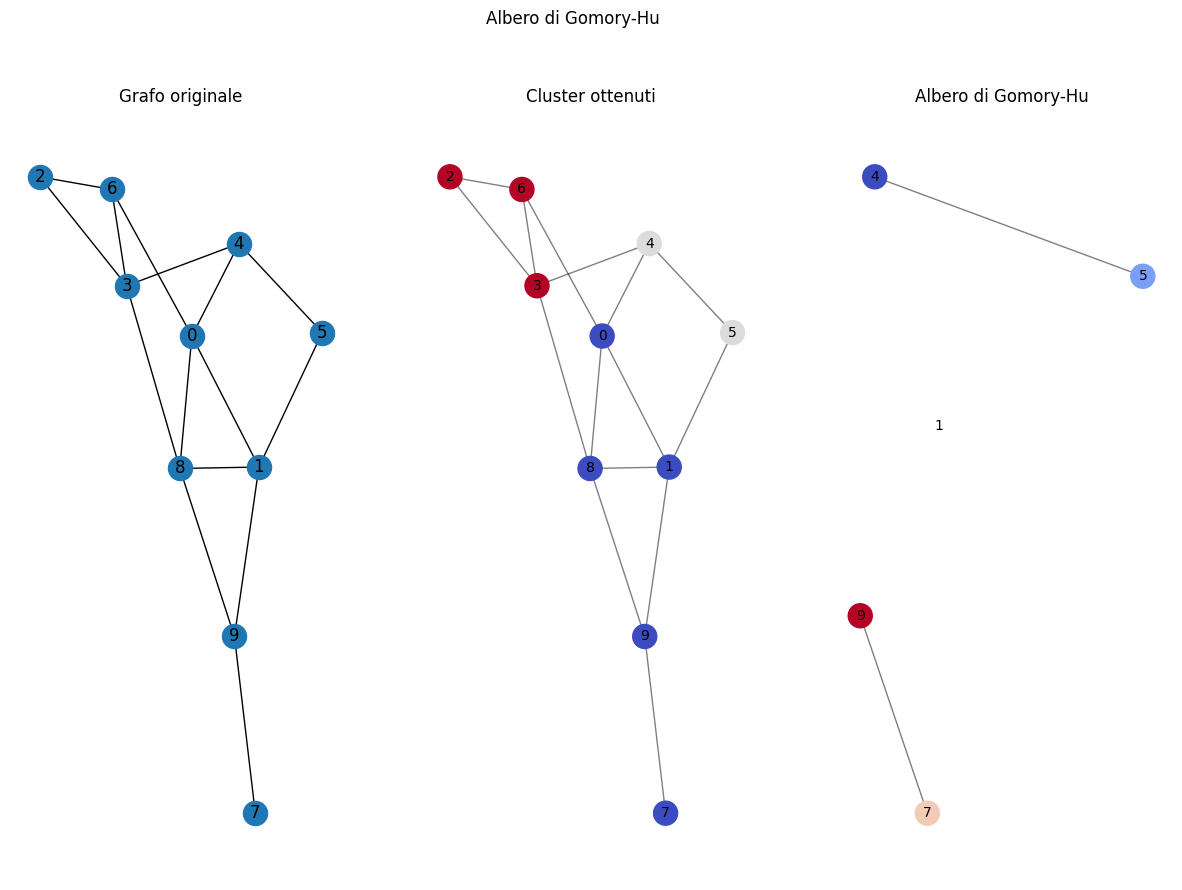

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
import pulp

import time

time_start = time.time()

# Imposta le opzioni di stampa del solver a "normale"
pulp.LpSolverDefault.msg = 0



def gomory_hu_tree(graph):
    # Creazione del problema di programmazione lineare intera (IP)
    prob = pulp.LpProblem("Gomory_Hu_Tree", pulp.LpMinimize)

    # Variabili continue che rappresentano i flussi sugli archi dell'albero di Gomory-Hu
    flows = pulp.LpVariable.dicts("flow", [(min(u, v), max(u, v)) for u, v in graph.edges()], lowBound=0, upBound=1, cat=pulp.LpContinuous)

    # Funzione obiettivo: minimizzare la somma dei flussi sugli archi
    prob += pulp.lpSum(flows[edge] for edge in flows)

    # Vincoli di flusso per i nodi del grafo
    for node in graph.nodes():
        # Il flusso totale in uscita da un nodo deve essere uguale a 1
        prob += pulp.lpSum(flows[(min(node, neighbor), max(node, neighbor))] for neighbor in graph.neighbors(node)) == 1

    # Risoluzione del problema di programmazione lineare intera
    prob.solve()

    # Creazione dell'albero di Gomory-Hu
    gomory_hu_tree = nx.Graph()
    for edge in flows:
        if pulp.value(flows[edge]) > 0.5:
            gomory_hu_tree.add_edge(edge[0], edge[1])

    return gomory_hu_tree

# Esempio di utilizzo
G = nx.gnm_random_graph(n=10, m=15, seed=42)

# Calcolo dell'albero di Gomory-Hu
gomory_hu_tree = gomory_hu_tree(G)

# Registra l'istante di fine dell'esecuzione
end_time = time.time()

# Calcola il tempo di esecuzione in secondi
execution_time = end_time - start_time

print("=====================================================")
print("Tempo di esecuzione:", execution_time, "secondi")
print("=====================================================")

# Per visualizzare i cluster
pos = nx.spring_layout(G)  # Layout per posizionare i nodi
plt.figure(figsize=(15, 10))  # Dimensione della figura
plt.suptitle("Albero di Gomory-Hu")

# Prima visualizzazione: Grafo originale con etichette dei nodi
plt.subplot(1, 3, 1)
plt.axis("off")
nx.draw_networkx(G, pos, with_labels=True)
plt.title("Grafo originale")

# Seconda visualizzazione: Cluster ottenuti da Louvain
plt.subplot(1, 3, 2)
plt.axis("off")
# Coloriamo i nodi in base all'etichetta del cluster
nx.draw_networkx_nodes(G, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(partition.values()))
nx.draw_networkx_edges(G, pos, alpha=0.5)
# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')
plt.title("Cluster ottenuti")

# Terza visualizzazione: Albero di Gomory-Hu
plt.subplot(1, 3, 3)
plt.axis("off")
# Coloriamo i nodi dell'albero di Gomory-Hu con un diverso colormap
# nx.draw_networkx_nodes(gomory_hu_tree, pos, node_size=300, cmap=plt.get_cmap("viridis"), node_color=list(gomory_hu_tree.nodes()))

nx.draw_networkx_nodes(gomory_hu_tree, pos, node_size=300, cmap=plt.get_cmap("coolwarm"), node_color=list(gomory_hu_tree.nodes()))
nx.draw_networkx_edges(gomory_hu_tree, pos, alpha=0.5)
# Aggiungi le label dei nodi originali (etichette dei nodi iniziali)
node_labels = {node: str(node) for node in G.nodes()}
nx.draw_networkx_labels(gomory_hu_tree, pos, labels=node_labels, font_size=10, font_color='black')
plt.title("Albero di Gomory-Hu")

plt.show()



Nell'albero di Gomory-Hu, i nodi che non sono colorati rappresentano i tagli di flusso minimi tra coppie di nodi nel grafo originale. Un taglio di flusso minimo è una partizione del grafo in due insiemi disgiunti di nodi, dove la somma dei pesi degli archi tra i due insiemi è la più piccola possibile.

Quando costruiamo l'albero di Gomory-Hu utilizzando un algoritmo di programmazione lineare intera (ILP), otteniamo flussi sugli archi con valori continui. I nodi che non sono colorati nell'albero di Gomory-Hu corrispondono a flussi che hanno valori non interi (valori frazionari).